# Color-DCT image compression

Compressing color images with PNG after applying the DCT to the color domain. The DCT is orthonormal (ortongonal + unitary) and energy preserving.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
!ln -sf ~/quantization/deadzone_quantizer.py .
!ln -sf ~/quantization/midtread_quantizer.py .
!ln -sf ~/quantization/midrise_quantizer.py .
!ln -sf ~/quantization/distortion.py .
!ln -sf ~/quantization/information.py .
!ln -sf ~/MRVC/src/YCrCb.py .
!ln -sf ~/MRVC/src/debug.py .
!ln -sf ~/MRVC/src/image_3.py .
!ln -sf ~/MRVC/src/image_1.py .
!ln -sf ../common.py .
import deadzone_quantizer as Q
import midtread_quantizer as midtread
import midrise_quantizer as midrise
import YCrCb
import distortion
import information
import image_3 as RGB_image
import image_1 as gray_image
import colored
import common

## Configuration

In [23]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
#fn = home + "/MRVC/sequences/stockholm/"
fn = home + "/MRVC/sequences/lena_color/"

DCT_components = ['0', '1', '2']

# Number of quantization steps.
N_Q_steps = 8
#Q_steps = [256*i/N_Q_steps for i in range(N_Q_steps + 1, 0, -1)]
Q_steps = [2**i for i in range(7, -1, -1)]
print(Q_steps)

quantizer = midtread
#quantizer = deadzone
#quantizer = midrise

[128, 64, 32, 16, 8, 4, 2, 1]


## Read the image and show it

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 


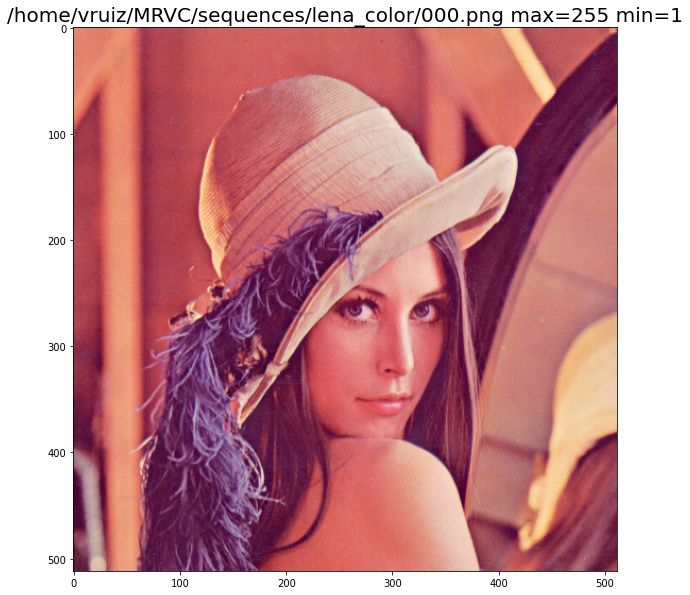

In [3]:
RGB_img = RGB_image.read(fn).astype(np.int16)
common.show(RGB_img, fn + "000.png")

In [4]:
RGB_img.shape

(512, 512, 3)

## (RGB -> ColorDCT) transform

In [5]:
import numpy as np
from scipy.fftpack import dct, idct

DCT_type = 3
norm = "ortho" # Orthonormal: orthogonal + unitary (unit gain in both directions of the transform)
#norm = None

In [6]:
def color_DCT(RGB_img):
    DCT_img = np.empty_like(RGB_img)
    for y in range(RGB_img.shape[0]):
        for x in range(RGB_img.shape[1]):
            DCT_img[y, x] = dct(RGB_img[y, x], type=DCT_type, norm=norm)
    return DCT_img

DCT_img = color_DCT(RGB_img)

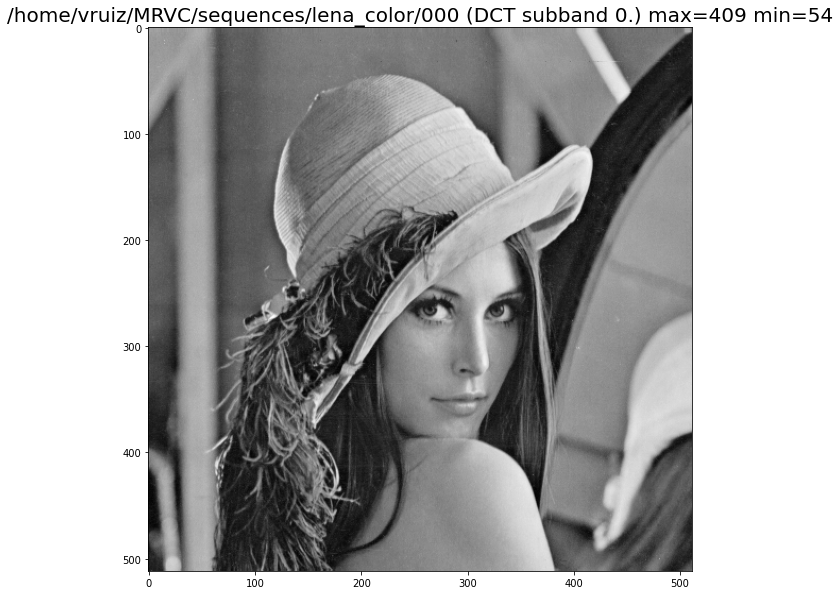

In [7]:
common.show_gray(DCT_img[..., 0], fn + "000 (DCT0)")

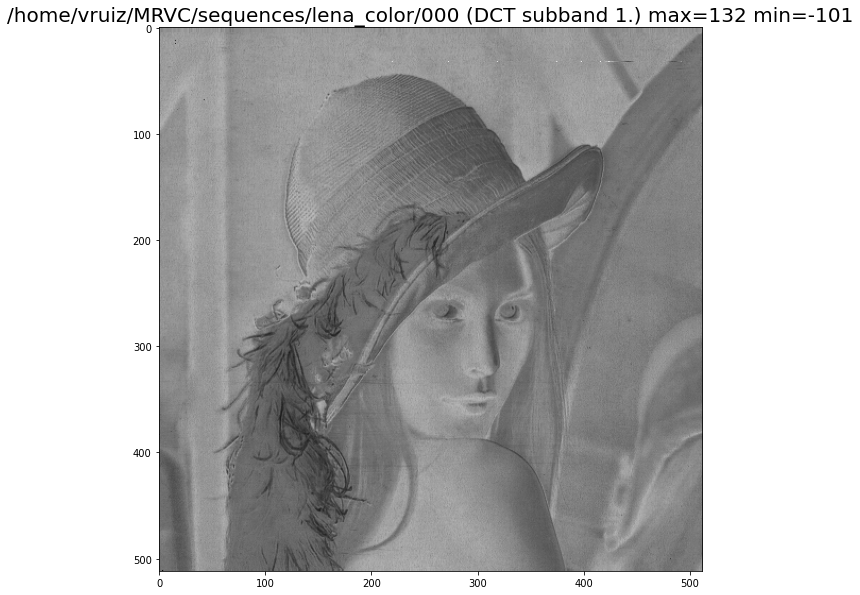

In [8]:
common.show_gray(DCT_img[..., 1], fn + "000 (DCT1)")

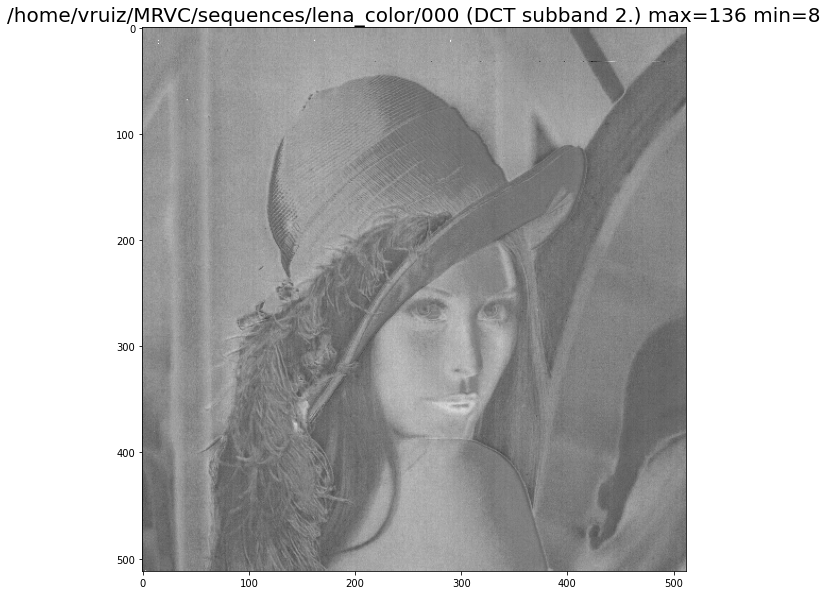

In [9]:
common.show_gray(DCT_img[..., 2], fn + "000 (DCT2)")

In [10]:
DCT_0_avg_energy = information.average_energy(DCT_img[..., 0])
DCT_1_avg_energy = information.average_energy(DCT_img[..., 1])
DCT_2_avg_energy = information.average_energy(DCT_img[..., 2])
print(f"Average energy DCT[..., 0] = {DCT_0_avg_energy}")
print(f"Average energy DCT[..., 1] = {DCT_1_avg_energy}")
print(f"Average energy DCT[..., 2] = {DCT_2_avg_energy}")
total_DCT_avg_energy = DCT_0_avg_energy + DCT_1_avg_energy + DCT_2_avg_energy
print(f"Total average energy (computed by adding the energies of the DCT coefficients) = {total_DCT_avg_energy}")
print(f"Total RGB average energy (computed directly from the RGB image) = {information.average_energy(RGB_img)*3}")

Average energy DCT[..., 0] = 52662.04672241211
Average energy DCT[..., 1] = 809.4176864624023
Average energy DCT[..., 2] = 5977.7565841674805
Total average energy (computed by adding the energies of the DCT coefficients) = 59449.22099304199
Total RGB average energy (computed directly from the RGB image) = 59766.590103149414


Therefore, the forward DCT is almost energy preserving.

## Is the RGB <-> YCrCb transform energy preserving?

In [11]:
def inverse_color_DCT(DCT_img):
    RGB_img = np.empty_like(DCT_img)
    for y in range(DCT_img.shape[0]):
        for x in range(DCT_img.shape[1]):
            RGB_img[y, x] = idct(DCT_img[y, x], type=DCT_type, norm=norm)
    return RGB_img

recons_RGB_img = inverse_color_DCT(DCT_img)

In [12]:
print(f"Total RGB average energy (computed from the reconstructed RGB image) = {information.average_energy(recons_RGB_img)*3}")

Total RGB average energy (computed from the reconstructed RGB image) = 59076.29767227173


And the same ca be said of the backward transform.

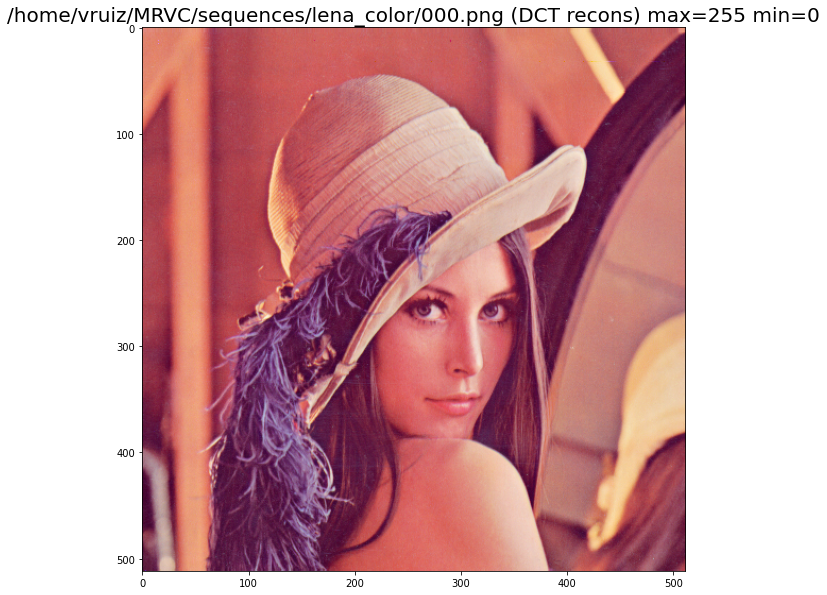

In [13]:
common.show(recons_RGB_img, fn + "000.png (DCT recons)")

## (RGB <-> ColorDCT) transform error

In [14]:
#RGB_img2 = YCrCb.to_RGB(DCT_img)

In [15]:
np.array_equal(RGB_img, recons_RGB_img)

False

In [16]:
print(RGB_img.max(), RGB_img.min())

255 1


In [17]:
print(recons_RGB_img.max(), recons_RGB_img.min())

255 0


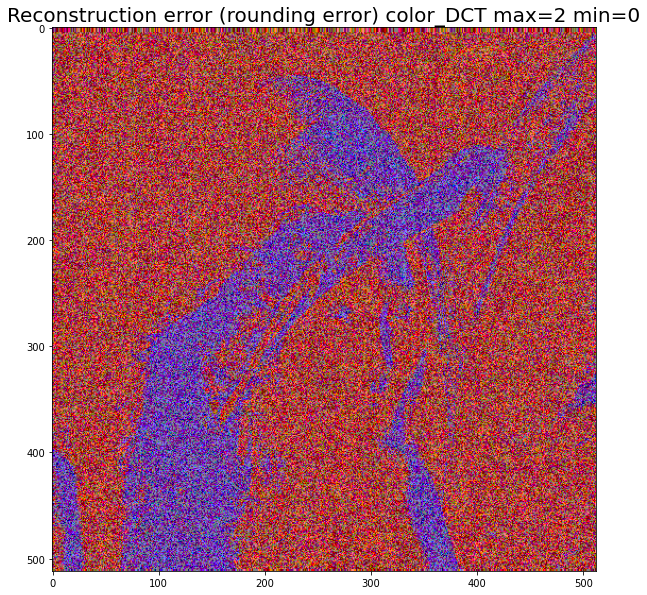

In [18]:
common.show(RGB_img-recons_RGB_img, "Reconstruction error (rounding error) color_DCT")

The DCT transform is irreversible. In general, only integer arithmetic operations guarantees reversibility.

## Synthesis filters gains

In [19]:
def print_info(val):
    delta_DCT0 = np.array([val, 0, 0])
    RGB_delta_DCT0 = idct(delta_DCT0, type=DCT_type, norm=norm)
    RGB_energy_delta_DCT0 = information.energy(RGB_delta_DCT0)
    delta_DCT1 = np.array([0, val, 0])
    RGB_delta_DCT1 = idct(delta_DCT1, type=DCT_type, norm=norm)
    RGB_energy_delta_DCT1 = information.energy(RGB_delta_DCT1)
    delta_DCT2 = np.array([0, 0, val])
    RGB_delta_DCT2 = idct(delta_DCT2, type=DCT_type, norm=norm)
    RGB_energy_delta_DCT2 = information.energy(RGB_delta_DCT2)
    print(f"Energy of {delta_DCT0} in the RGB domain = {RGB_energy_delta_DCT0}")
    print(f"Energy of {delta_DCT1} in the RGB domain = {RGB_energy_delta_DCT1}")
    print(f"Energy of {delta_DCT2} in the RGB domain = {RGB_energy_delta_DCT2}")
    max_ = max(RGB_energy_delta_DCT0, RGB_energy_delta_DCT1, RGB_energy_delta_DCT2)
    relative_DCT0_gain = RGB_energy_delta_DCT0 / max_
    relative_DCT1_gain = RGB_energy_delta_DCT1 / max_
    relative_DCT2_gain = RGB_energy_delta_DCT2 / max_
    print(f"Relative gain of DCT0 component = {relative_DCT0_gain}")
    print(f"Relative gain of DCT1 component = {relative_DCT1_gain}")
    print(f"Relative gain of DCT2 component = {relative_DCT2_gain}")
    
print_info(255)
print_info(1)
print_info(0)

Energy of [255   0   0] in the RGB domain = 65025.000000000015
Energy of [  0 255   0] in the RGB domain = 65025.00000000001
Energy of [  0   0 255] in the RGB domain = 65025.000000000015
Relative gain of DCT0 component = 1.0
Relative gain of DCT1 component = 0.9999999999999999
Relative gain of DCT2 component = 1.0
Energy of [1 0 0] in the RGB domain = 1.0000000000000002
Energy of [0 1 0] in the RGB domain = 1.0
Energy of [0 0 1] in the RGB domain = 1.0000000000000002
Relative gain of DCT0 component = 1.0
Relative gain of DCT1 component = 0.9999999999999998
Relative gain of DCT2 component = 1.0
Energy of [0 0 0] in the RGB domain = 0.0
Energy of [0 0 0] in the RGB domain = 0.0
Energy of [0 0 0] in the RGB domain = 0.0
Relative gain of DCT0 component = nan
Relative gain of DCT1 component = nan
Relative gain of DCT2 component = nan


<ipython-input-19-73879e9263dd>:15: RuntimeWarning: invalid value encountered in double_scalars
  relative_DCT0_gain = RGB_energy_delta_DCT0 / max_
<ipython-input-19-73879e9263dd>:16: RuntimeWarning: invalid value encountered in double_scalars
  relative_DCT1_gain = RGB_energy_delta_DCT1 / max_
<ipython-input-19-73879e9263dd>:17: RuntimeWarning: invalid value encountered in double_scalars
  relative_DCT2_gain = RGB_energy_delta_DCT2 / max_


The gain of each DCT inverse filter is 1.

## Simple quantization in the DCT domain ($\Delta_{\text{DCT0}} = \Delta_{\text{DCT1}} = \Delta_{\text{DCT2}}$)
Notice that the distortion cab be measured in both, the RGB and the DCT domains.

In [20]:
def DCT_same_delta_RD_curve(RGB_img, Q_steps, quantizer):
    DCT_img = color_DCT(RGB_img)#.astype(np.int16)
    DCT_img[..., 0] -= 128
    points = []
    for Q_step in Q_steps:
        y_DCT, k = quantizer.quan_dequan(DCT_img, Q_step)
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_color_pixel(k, str(Q_step) + '_')
        #y_DCT[..., 0] += 128                         # Uncomment these lines for measuring
        #y_RGB = inverse_color_IDCT(y_DCT)            # the distortion in the
        #_distortion = distortion.MSE(RGB_img, y_RGB) # RGB domain.
        _distortion = distortion.MSE(DCT_img, y_DCT) # Uncomment this line for measuring the distortion in the DCT domain
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

DCT_same_delta_RD_points = DCT_same_delta_RD_curve(RGB_img, Q_steps, quantizer)

image_3.write: /tmp/128_000.png (512, 512, 3) uint8 49679 
q_step=128, rate=1.516082763671875 bits/pixel, distortion=1556.1
image_3.write: /tmp/64_000.png (512, 512, 3) uint8 83586 
q_step= 64, rate=2.55084228515625 bits/pixel, distortion= 339.4
image_3.write: /tmp/32_000.png (512, 512, 3) uint8 122150 
q_step= 32, rate=3.72772216796875 bits/pixel, distortion=  82.3
image_3.write: /tmp/16_000.png (512, 512, 3) uint8 177536 
q_step= 16, rate=5.41796875 bits/pixel, distortion=  21.6
image_3.write: /tmp/8_000.png (512, 512, 3) uint8 240750 
q_step=  8, rate=7.34710693359375 bits/pixel, distortion=   5.5
image_3.write: /tmp/4_000.png (512, 512, 3) uint8 318975 
q_step=  4, rate=9.734344482421875 bits/pixel, distortion=   1.5
image_3.write: /tmp/2_000.png (512, 512, 3) uint8 407700 
q_step=  2, rate=12.4420166015625 bits/pixel, distortion=   0.5
image_3.write: /tmp/1_000.png (512, 512, 3) uint8 506363 
q_step=  1, rate=15.452972412109375 bits/pixel, distortion=   0.0


## Better RD curves?

The method `same_delta_RD_curve(img, Q_steps, quantizer)` generates a RD curve where each point is the result of using $\Delta_{\text{Y}} = \Delta_{\text{Cb}} = \Delta_{\text{Cr}}$. However, a better (at least with more points) RD curve can be generated with:

1. Convert the image from RGB to YCrCb.
2. The RD curve of each YCrCb channel is computed, for a number of quantization steps, measuring the distortion in the RGB domain (remember that the YCrCb transform is not orthogonal and therefore, the distortion in the RGB domain cannot be estimated in the YCrCb domain).
3. Compute the slope of each segment of the RD curve. Except for the most left point, the slopes are computed as the average between the slopes of the straight lines that connect to the corresponding point.


Such slope will be asigned to the point of the left extreme of the corresponding segment.


YCrCb domain. Remember that the YCrCb transform is not orthogonal and therefore, the distortion in the RGB domain cannot be estimated in the YCrCb domain. However, we can suppose that if the quality of a YCrCb channel is incremented, the quality of the RGB reconstruction should also increases. We will call to each point of such curves, a TP (truncation Point).
3. The RD curve is obtained after sorting by slopes the TPs obtained in the previous step. We define the slope of a point as the slope of the straight line that connects such point with the neighbor point with a higher distortion in the curve. For the left-most TP, we will suppose an "infinite" distortion and a zero rate.

In [24]:
def component_RD_curve_(component, Q_steps, quantizer, component_name):
    assert component.dtype == np.int64
    component -= 128
    points = []
    for Q_step in Q_steps:
        y, k = quantizer.quan_dequan(component, Q_step)
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_gray_pixel(k, component_name + str(Q_step) + '_')
        _distortion = distortion.MSE(component, y)
        points.append((rate, _distortion, component_name, Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return points

def component_RD_curve(RGB_img, Q_steps, quantizer, components, component_name):
    YCrCb_img = YCrCb.from_RGB(RGB_img).astype(np.int16)
    YCrCb_img -= 128
    points = []
    component_index = components.index(component_name)
    for Q_step in Q_steps:
        component_img = YCrCb_img[...,component_index]
        y = np.zeros_like(YCrCb_img)
        y[..., component_index], k = quantizer.quan_dequan(component_img, Q_step)
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_gray_pixel(k[..., component_index], component_name + str(Q_step) + '_')
        y_RGB = YCrCb.to_RGB(y + 128)
        _distortion = distortion.MSE(RGB_img, y_RGB)
        #common.show(y_RGB, '')
        points.append((rate, _distortion, component_name, Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return points

def croma_component_RD_curve(RGB_img, Q_steps, quantizer, components, component_name):
    YCrCb_img = YCrCb.from_RGB(RGB_img).astype(np.int16)
    YCrCb_img -= 128
    points = []
    component_index = components.index(component_name)
    for Q_step in Q_steps:
        component_img = YCrCb_img[...,component_index]
        y = np.zeros_like(YCrCb_img)
        y[..., 0], _ = quantizer.quan_dequan(YCrCb_img[...,0], Q_step)
        y[..., component_index], k = quantizer.quan_dequan(component_img, Q_step)
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_gray_pixel(k, component_name + str(Q_step) + '_')
        y_RGB = YCrCb.to_RGB(y + 128)
        _distortion = distortion.MSE(RGB_img, y_RGB)
        #common.show(y_RGB, '')
        points.append((rate, _distortion, component_name, Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return points

def YCrCb_RD_curve_per_component_(RGB_img, Q_steps, Q, components):
    YCrCb_img = YCrCb.from_RGB(RGB_img).astype(np.int16)
    YCrCb_img -= 128
    N_components = len(components)
    RD_points = N_components*[[]]
    for Q_step in Q_steps:
        YCrCb_k = Q.quantize(YCrCb_img, Q_step)
        for component_index in range(N_components):
            YCrCb_y = np.zeros_like(YCrCb_img)
            YCrCb_y[..., component_index] = Q.dequantize(YCrCb_k[..., component_index], Q_step) + 128
            rate = common.bits_per_gray_pixel(YCrCb_k[..., component_index] + 128, str(Q_step) + '_' + str(components[component_index]))
            RGB_y = YCrCb.to_RGB(YCrCb_y)
            _distortion = distortion.MSE(RGB_img, RGB_y)
            common.show(RGB_y, str(Q_step))
            RD_points[component_index].append((rate, _distortion))
            print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

def color_DCT_RD_curve_per_component(RGB_img, Q_steps, Q, components):
    DCT_img = color_DCT(RGB_img)
    DCT_img[..., 0] -= 128
    N_components = len(components)
    RD_points = []
    for c in range(N_components):
        RD_points.append([])
    for Q_step in Q_steps:
        DCT_k = Q.quantize(DCT_img, Q_step)
        for component_index in range(N_components):
            component_name = components[component_index]
            DCT_y = Q.dequantize(DCT_k[..., component_index], Q_step)
            rate = common.bits_per_gray_pixel(DCT_k[..., component_index] + 128, str(Q_step) + '_' + component_name)
            _distortion = distortion.MSE(DCT_img[..., component_index], DCT_y)
            #common.show(RGB_y, components[component_index] + ' ' + str(Q_step))
            RD_points[component_index].append((rate, _distortion, component_name, Q_step))
            print(f"{components[component_index]} q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points
               
DCT_curve_per_component = color_DCT_RD_curve_per_component(RGB_img, Q_steps, quantizer, DCT_components)
DCT_curve_per_component

bytes_per_gray_img: /tmp/128_0000.png (512, 512) int64 19092 
0 q_step=128, rate=0.5826416015625 bits/pixel, distortion=1229.8
bytes_per_gray_img: /tmp/128_1000.png (512, 512) int64 1688 
1 q_step=128, rate=0.051513671875 bits/pixel, distortion= 808.5
bytes_per_gray_img: /tmp/128_2000.png (512, 512) int64 19510 
2 q_step=128, rate=0.59539794921875 bits/pixel, distortion=2629.9
bytes_per_gray_img: /tmp/64_0000.png (512, 512) int64 35962 
0 q_step= 64, rate=1.09747314453125 bits/pixel, distortion= 371.9
bytes_per_gray_img: /tmp/64_1000.png (512, 512) int64 23384 
1 q_step= 64, rate=0.713623046875 bits/pixel, distortion= 379.8
bytes_per_gray_img: /tmp/64_2000.png (512, 512) int64 6114 
2 q_step= 64, rate=0.18658447265625 bits/pixel, distortion= 266.5
bytes_per_gray_img: /tmp/32_0000.png (512, 512) int64 49289 
0 q_step= 32, rate=1.504180908203125 bits/pixel, distortion=  84.5
bytes_per_gray_img: /tmp/32_1000.png (512, 512) int64 35821 
1 q_step= 32, rate=1.093170166015625 bits/pixel, dist

[[(0.5826416015625, 1229.8465270996094, '0', 128),
  (1.09747314453125, 371.9129333496094, '0', 64),
  (1.504180908203125, 84.47152709960938, '0', 32),
  (2.17303466796875, 21.575775146484375, '0', 16),
  (2.93756103515625, 5.482147216796875, '0', 8),
  (3.84063720703125, 1.50286865234375, '0', 4),
  (4.77655029296875, 0.5000457763671875, '0', 2),
  (4.3162841796875, 0.0, '0', 1)],
 [(0.051513671875, 808.5221786499023, '1', 128),
  (0.713623046875, 379.75948333740234, '1', 64),
  (1.093170166015625, 84.77584075927734, '1', 32),
  (1.665496826171875, 21.024986267089844, '1', 16),
  (2.324554443359375, 5.436790466308594, '1', 8),
  (3.15618896484375, 1.4822921752929688, '1', 4),
  (4.0543212890625, 0.49542999267578125, '1', 2),
  (5.089874267578125, 0.0, '1', 1)],
 [(0.59539794921875, 2629.8532638549805, '2', 128),
  (0.18658447265625, 266.48119354248047, '2', 64),
  (0.592376708984375, 77.73876190185547, '2', 32),
  (1.18304443359375, 22.24925994873047, '2', 16),
  (1.7781982421875, 5.5

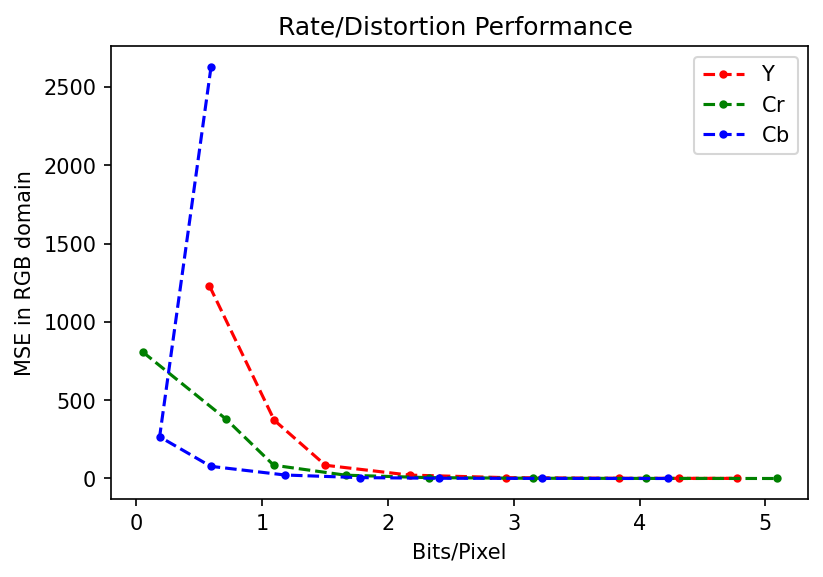

In [25]:
pylab.figure(dpi=150)
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT_curve_per_component[0]]), c='r', marker='.', label="$\mathrm{Y}}$", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT_curve_per_component[1]]), c='g', marker='.', label="$\mathrm{Cr}}$", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT_curve_per_component[2]]), c='b', marker='.', label="$\mathrm{Cb}}$", linestyle="dashed")
#pylab.plot(*zip(*YCrCb_curve_per_component[0]), c='r', marker='.', label="$\mathrm{Y}}$", linestyle="dashed")
#pylab.plot(*zip(*YCrCb_curve_per_component[1]), c='g', marker='.', label="$\mathrm{Cr}$", linestyle="dashed")
#pylab.plot(*zip(*YCrCb_curve_per_component[2]), c='b', marker='.', label="$\mathrm{Cb}$", linestyle="dashed")
#pylab.plot(*zip(*[(i[0], i[1]) for i in Cr_curve]), c='g', marker='.', label="Cr", linestyle="dashed")
#pylab.plot(*zip(*[(i[0], i[1]) for i in Cb_curve]), c='b', marker='.', label="Cb", linestyle="dashed")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

In [27]:
def compute_slopes_(RD_points):
    extended_RD_points = [(0.0, 9.0E9, '', -1)] + RD_points
    counter = 0
    RD_slopes = []
    for i in RD_points:
        BPP = i[0] # Rate 
        #print(RD_points[counter])
        delta_BPP = BPP - extended_RD_points[counter][0]
        MSE = i[1] # Distortion
        delta_MSE = MSE - extended_RD_points[counter][1] 
        #print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        if delta_BPP > 0:
            slope = delta_MSE/delta_BPP
        else:
            slope = 0
        print((slope, i), delta_MSE, delta_BPP)
        RD_slopes.append((slope, i[2], i[3]))
        counter += 1
    return RD_slopes

def compute_slope(left_BPP, left_MSE, right_BPP, right_MSE):
    delta_BPP = right_BPP - left_BPP
    delta_MSE = left_MSE - right_MSE
    if delta_BPP > 0:
        slope = delta_MSE / delta_BPP
    else:
        slope = 0
    return slope

def compute_slopes(RD_points):
    counter = 0
    _RD_slopes = []
    points_iterator = iter(RD_points)
    left = next(points_iterator)
    left_BPP = left[0]
    left_MSE = left[1]
    right = next(points_iterator)
    right_BPP = right[0]
    right_MSE = right[1]
    slope = compute_slope(left_BPP, left_MSE, right_BPP, right_MSE)
    _RD_slopes.append((slope, left[2], left[3]))
    _RD_slopes.append((slope, right[2], right[3]))
    left = right
    for right in points_iterator:
        right_BPP = right[0]
        right_MSE = right[1]
        #print(RD_points[counter])
        slope = compute_slope(left_BPP, left_MSE, right_BPP, right_MSE)
        _RD_slopes.append((slope, right[2], right[3]))
        counter += 1
        left = right
        left_BPP = left[0]
        left_MSE = left[1]
        #left_BPP = right_BPP
        #left_MSE = right_MSE
    RD_slopes = []
    slopes_iterator = iter(_RD_slopes)
    left = next(slopes_iterator)
    #print("-->",_RD_slopes)
    #return _RD_slopes
    #RD_slopes.append(left)
    #print(left)
    for right in slopes_iterator:
        #print(left, right)
        RD_slopes.append((((left[0] + right[0])/2), right[1], left[2]))
        left = right
    RD_slopes.append(right)
    return RD_slopes

#print("(Slope (rate, distortion, component, Q_step)) delta_MSE delta_BPP:\n")
Y_slopes = compute_slopes(DCT_curve_per_component[0])
Cr_slopes = compute_slopes(DCT_curve_per_component[1])
Cb_slopes = compute_slopes(DCT_curve_per_component[2])

In [28]:
Y_slopes

[(1666.4355660936574, '0', 128),
 (1454.6644168183952, '0', 64),
 (668.464200044323, '0', 32),
 (57.54279379950068, '0', 16),
 (12.728407440234504, '0', 8),
 (2.7389256419367216, '0', 4),
 (0.5357457284465893, '0', 2),
 (0, '0', 1)]

In [29]:
Cr_slopes

[(647.570796460177, '1', 128),
 (671.1870330116782, '1', 64),
 (403.0960999623511, '1', 32),
 (67.52059038913336, '1', 16),
 (14.203670986508502, '1', 8),
 (2.926942652074741, '1', 4),
 (0.7886072296390985, '1', 2),
 (0.4784207114018802, '1', 1)]

In [30]:
Cb_slopes

[(0.0, '2', 128),
 (0.0, '2', 64),
 (46.97184190131749, '2', 32),
 (61.03850173107854, '2', 16),
 (17.256327582837862, '2', 8),
 (3.8048885555874588, '2', 4),
 (0.8637865134918994, '2', 2),
 (0.49713142196250304, '2', 1)]

Sort the slopes at each quantization step. The TPs generated in a component must be used in order.

In [31]:
_i = 0
sorted_slopes = []
#print(Q_steps)
for _Q_step in range(len(Q_steps)):
    #print(_i)
    YCrCb_slopes_for_such_Q_step = [Y_slopes[_i], Cr_slopes[_i], Cb_slopes[_i]]
    sorted_slopes.append(sorted(YCrCb_slopes_for_such_Q_step, key=lambda x: x[0])[::-1])
    #sorted_slopes.append(YCrCb_slopes_for_such_Q_step)
    #print(YCrCb_slopes_for_such_Q_step)
    _i += 1

#all_slopes = Y_slopes + Cr_slopes + Cb_slopes
#sorted_slopes = sorted(all_slopes, key=lambda x: x[0])[::-1]
sorted_slopes

[[(1666.4355660936574, '0', 128),
  (647.570796460177, '1', 128),
  (0.0, '2', 128)],
 [(1454.6644168183952, '0', 64), (671.1870330116782, '1', 64), (0.0, '2', 64)],
 [(668.464200044323, '0', 32),
  (403.0960999623511, '1', 32),
  (46.97184190131749, '2', 32)],
 [(67.52059038913336, '1', 16),
  (61.03850173107854, '2', 16),
  (57.54279379950068, '0', 16)],
 [(17.256327582837862, '2', 8),
  (14.203670986508502, '1', 8),
  (12.728407440234504, '0', 8)],
 [(3.8048885555874588, '2', 4),
  (2.926942652074741, '1', 4),
  (2.7389256419367216, '0', 4)],
 [(0.8637865134918994, '2', 2),
  (0.7886072296390985, '1', 2),
  (0.5357457284465893, '0', 2)],
 [(0.49713142196250304, '2', 1), (0.4784207114018802, '1', 1), (0, '0', 1)]]

In [32]:
one_list = []
for _list in sorted_slopes:
    one_list += _list
    print(_list)
one_list

[(1666.4355660936574, '0', 128), (647.570796460177, '1', 128), (0.0, '2', 128)]
[(1454.6644168183952, '0', 64), (671.1870330116782, '1', 64), (0.0, '2', 64)]
[(668.464200044323, '0', 32), (403.0960999623511, '1', 32), (46.97184190131749, '2', 32)]
[(67.52059038913336, '1', 16), (61.03850173107854, '2', 16), (57.54279379950068, '0', 16)]
[(17.256327582837862, '2', 8), (14.203670986508502, '1', 8), (12.728407440234504, '0', 8)]
[(3.8048885555874588, '2', 4), (2.926942652074741, '1', 4), (2.7389256419367216, '0', 4)]
[(0.8637865134918994, '2', 2), (0.7886072296390985, '1', 2), (0.5357457284465893, '0', 2)]
[(0.49713142196250304, '2', 1), (0.4784207114018802, '1', 1), (0, '0', 1)]


[(1666.4355660936574, '0', 128),
 (647.570796460177, '1', 128),
 (0.0, '2', 128),
 (1454.6644168183952, '0', 64),
 (671.1870330116782, '1', 64),
 (0.0, '2', 64),
 (668.464200044323, '0', 32),
 (403.0960999623511, '1', 32),
 (46.97184190131749, '2', 32),
 (67.52059038913336, '1', 16),
 (61.03850173107854, '2', 16),
 (57.54279379950068, '0', 16),
 (17.256327582837862, '2', 8),
 (14.203670986508502, '1', 8),
 (12.728407440234504, '0', 8),
 (3.8048885555874588, '2', 4),
 (2.926942652074741, '1', 4),
 (2.7389256419367216, '0', 4),
 (0.8637865134918994, '2', 2),
 (0.7886072296390985, '1', 2),
 (0.5357457284465893, '0', 2),
 (0.49713142196250304, '2', 1),
 (0.4784207114018802, '1', 1),
 (0, '0', 1)]

Crominance without luminance makes not sense from a visual point of view, but these are the number :-/

In [33]:
#sorted_slopes[0], sorted_slopes[2] = sorted_slopes[2], sorted_slopes[0]
#sorted_slopes

And finally, let's compute the RD curve (remember that the previous points are only an estimation of the order in which the quantization steps should be increased in each component to build the RD curve, not the real RD curve that measures the distortion in the RGB domain).

In [35]:
def generate_curve(RGB_img, sorted_slopes, quantizer, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    YCrCb_img = YCrCb.from_RGB(RGB_img).astype(np.int16)
    k = np.empty_like(YCrCb_img)
    y = np.empty_like(YCrCb_img)
    YCrCb_img -= 128
    for i in sorted_slopes:
        print(i)
        #point = i[1]
        #component = point[2]
        #Q_step = point[3]
        component, Q_step = i[1], i[2]
        Q_steps_per_component[components.index(component)] = Q_step
        for c, Q_step in zip(components, Q_steps_per_component):
            component_index = components.index(c)
            y[..., component_index], k[..., component_index] = quantizer.quan_dequan(YCrCb_img[..., component_index], Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_color_pixel(k, str(Q_steps_per_component) + '_')
        y_RGB = YCrCb.to_RGB(y + 128)
        _distortion = distortion.MSE(RGB_img, y_RGB)
        #common.show(y_RGB, f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

sorted_points = generate_curve(RGB_img, one_list, quantizer, DCT_components)
sorted_points

(1666.4355660936574, '0', 128)
image_3.write: /tmp/[128, 256, 256]_000.png (512, 512, 3) uint8 22913 
Q_step=[128, 256, 256], rate=0.699249267578125 bits/pixel, distortion=3129.8
(647.570796460177, '1', 128)
image_3.write: /tmp/[128, 128, 256]_000.png (512, 512, 3) uint8 24085 
Q_step=[128, 128, 256], rate=0.735015869140625 bits/pixel, distortion=3122.4
(0.0, '2', 128)
image_3.write: /tmp/[128, 128, 128]_000.png (512, 512, 3) uint8 24094 
Q_step=[128, 128, 128], rate=0.73529052734375 bits/pixel, distortion=3122.3
(1454.6644168183952, '0', 64)
image_3.write: /tmp/[64, 128, 128]_000.png (512, 512, 3) uint8 32881 
Q_step=[64, 128, 128], rate=1.003448486328125 bits/pixel, distortion=1982.6
(671.1870330116782, '1', 64)
image_3.write: /tmp/[64, 64, 128]_000.png (512, 512, 3) uint8 51835 
Q_step=[64, 64, 128], rate=1.581878662109375 bits/pixel, distortion= 946.6
(0.0, '2', 64)
image_3.write: /tmp/[64, 64, 64]_000.png (512, 512, 3) uint8 57308 
Q_step=[64, 64, 64], rate=1.7489013671875 bits/pi

[(0.699249267578125, 3129.7782440185547),
 (0.735015869140625, 3122.3749033610025),
 (0.73529052734375, 3122.298066457113),
 (1.003448486328125, 1982.5629908243816),
 (1.581878662109375, 946.5763804117838),
 (1.7489013671875, 930.237419128418),
 (2.48431396484375, 782.5701599121094),
 (2.580902099609375, 470.9858093261719),
 (3.17352294921875, 276.7490882873535),
 (3.42401123046875, 222.51275380452475),
 (3.59954833984375, 126.79081726074219),
 (4.204376220703125, 62.20196533203125),
 (4.757080078125, 44.85155359903971),
 (5.15765380859375, 31.82724126180013),
 (5.95806884765625, 16.496880849202473),
 (6.6695556640625, 12.073129018147787),
 (7.104278564453125, 8.6335817972819),
 (7.982086181640625, 4.628838857014974),
 (8.920166015625, 3.6222966512044272),
 (9.465850830078125, 2.8615010579427085),
 (10.4193115234375, 1.8626810709635417),
 (11.5732421875, 1.3002777099609375),
 (12.341766357421875, 0.8800671895345052),
 (13.488800048828125, 0.37890370686848956)]

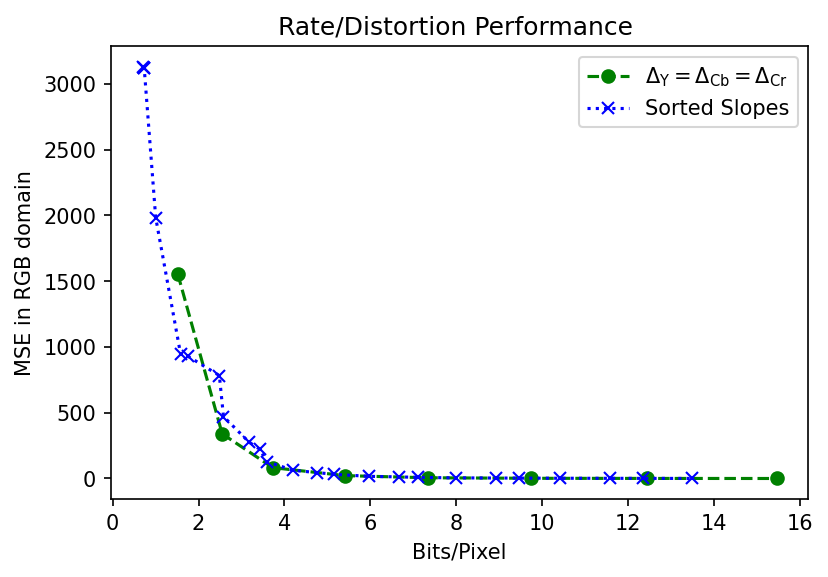

In [36]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_same_delta_RD_points), c='g', marker='o', label="$\Delta_{\mathrm{DCT0}} = \Delta_{\mathrm{DCT1}} = \Delta_{\mathrm{DCT2}}$", linestyle="dashed")
pylab.plot(*zip(*sorted_points), c='b', marker='x', label="Sorted Slopes", linestyle="dotted")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

## Again, let's compare to an orthogonal transform

In [ ]:
def DCT_RD_curve(RGB_img, Q_steps, quantizer, components, component_name):
    DCT_img = np.empty_like(RGB_img)
    for _y in range(RGB_img.shape[1]):
        for _x in range(RGB_img.shape[0]):
            DCT_img[_y, _x, :] = dct(RGB_img[_y, _x, :], type=DCT_type, norm=norm)
    DCT_img -= 128
    points = []
    component_index = components.index(component_name)
    for Q_step in Q_steps:
        component_img = DCT_img[...,component_index]
        y = np.zeros_like(DCT_img[..., component_index])
        y, k = quantizer.quan_dequan(component_img, Q_step)
        common.show(y,str(Q_step))
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_gray_pixel(k, str(component_name) + str(Q_step) + '_')
        _distortion = distortion.MSE(DCT_img[..., component_index], y)
        points.append((rate, _distortion, component_name, Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return points

print("DCT0:")
DCT0_curve = DCT_RD_curve(RGB_img, Q_steps, quantizer, DCT_components, 0)
print("\nDCT1:")
DCT1_curve = DCT_RD_curve(RGB_img, Q_steps, quantizer, DCT_components, 1)
print("\nDCT2:")
DCT2_curve = DCT_RD_curve(RGB_img, Q_steps, quantizer, DCT_components, 2)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT0_curve]), c='r', marker='.', label="DCT0", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT1_curve]), c='g', marker='.', label="DCT1", linestyle="dashed")
pylab.plot(*zip(*[(i[0], i[1]) for i in DCT2_curve]), c='b', marker='.', label="DCT2", linestyle="dashed")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
#print("(Slope (rate, distortion, component, Q_step)) delta_MSE delta_BPP:\n")
DCT0_slopes = compute_slopes(DCT0_curve)
#print()
DCT1_slopes = compute_slopes(DCT1_curve)
#print()
DCT2_slopes = compute_slopes(DCT2_curve)

In [ ]:
all_DCT_slopes = DCT0_slopes + DCT1_slopes + DCT2_slopes
sorted_DCT_slopes = sorted(all_DCT_slopes, key=lambda x: x[0])[::-1]
sorted_DCT_slopes

In [ ]:
def generate_curve(RGB_img, sorted_slopes, quantizer, components):
    print(components)
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    DCT_img = np.empty_like(RGB_img)
    for _y in range(RGB_img.shape[0]):
        for _x in range(RGB_img.shape[1]):
            DCT_img[_y, _x, :] = dct(RGB_img[_y, _x, :], type=DCT_type, norm=norm)
    k = np.empty_like(DCT_img)
    y = np.empty_like(DCT_img)
    DCT_img -= 128
    for i in sorted_slopes:
        #print(i)
        component, Q_step = i[1], i[2]
        Q_steps_per_component[components.index(component)] = Q_step
        for c, Q_step in zip(components, Q_steps_per_component):
            component_index = components.index(c)
            y[..., component_index], k[..., component_index] = quantizer.quan_dequan(DCT_img[..., component_index], Q_step)
        k = (k + 128).astype(np.uint8)
        rate = common.bits_per_color_pixel(k, str(Q_steps_per_component) + '_')
        #y_RGB = YCrCb.to_RGB(y + 128)
        #y_RGB = np.empty_like(y)
        #print(RGB_img.shape)
        #for _y in range(RGB_img.shape[0]):
        #    print('.', flush=True)
        #    for _x in range(RGB_img.shape[1]):
        #        y_RGB[y, x, :] = idct(y[_y, _x, :], type=DCT_type, norm=norm)
        #_distortion = distortion.MSE(RGB_img, y_RGB)
        _distortion = distortion.MSE(y, DCT_img)
        #common.show(y, f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

sorted_DCT_points = generate_curve(RGB_img, sorted_DCT_slopes, quantizer, DCT_components)
sorted_DCT_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*same_delta_RD_points), c='g', marker='o', label="$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Cb}} = \Delta_{\mathrm{Cr}}$", linestyle="dashed")
pylab.plot(*zip(*sorted_DCT_points), c='b', marker='x', label="DCT", linestyle="dotted")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE in RGB domain")
pylab.legend(loc='upper right')
pylab.show()

## Conclusion

Although slightly better RD curves can be found performing RDO, the lack of orthogonality of the YCrCb difficults the quantization of the components in this domain.

## Ignore the rest

In [ ]:
pylab.figure(dpi=150)
#pylab.plot(*zip(*YCrCb_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Cr}} = \Delta_{\mathrm{Cb}}$')
pylab.scatter(*zip(*[(i[0], i[1]) for i in Y_points_same_deltas]), c='r', marker=".", s=0.5, label='Y',)              
pylab.scatter(*zip(*[(i[0], i[1]) for i in Cr_points_same_deltas]), c='g', marker=".", s=0.5, label='Cr')              
pylab.scatter(*zip(*[(i[0], i[1]) for i in Cb_points_same_deltas]), c='b', marker=".", s=0.5, label='Cb')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in Y_points_gain_deltas]), c='r', marker=".", s=0.5, label='Only Y', linestyle="dotted")              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in Cb_points_gain_deltas]), c='b', marker=".", s=0.5, label='Only Cb', linestyle="dotted")              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Build the RD curve

Progressively quantize the image using the Q_steps described in the sorted list of monotonously decreasing slopes, and then, compute the distortion and the bit-rate. Remember that the quantization indexes images must be normalized or equalized to be displayed properly, and also, that they are in the YUV domain.

In [ ]:
# Falta hacer la transformada!!

def YCrCb_get_suboptimal_RD_curve(RGB_img, sorted_slopes, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    for _y in range(RGB_img.shape[1]):
        for _x in range(RGB_img.shape[0]):
            DCT_img[_y, _x, :] = dct(RGB_img[_y, _x, :], type=DCT_type, norm=norm)
    for i in sorted_slopes:
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c,Q_step in zip(components, Q_steps_per_component):
            k[..., components.index(c)], y[..., components.index(c)] = q_deq(YCrCb_img[..., components.index(c)], Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        #_distortion = distortion.MSE(YCrCb_img, y)
        #YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCrCb.to_RGB(y)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

YCrCb_suboptimal_points = YCrCb_get_suboptimal_RD_curve(img, sorted_YCrCb_slopes, ['Yrb', 'Cr', 'Cb'])

## Build the optimal RD curve

Neither YCrCb nor YCoCg are orthogonal spaces, which means that even considering the channel gains, the contributions of the channels to the quality of the reconstruction are not additive (the channels are not independent). This implies that the search of the optimal QSs cannot be done by simply sorting the slopes of each OTP of each channel, but by searching for each OTP the best combination of QSs, that not necessarily need to be embbeded (i.e., it can not be asserted that the optimal QSs for a quality level Q generated by a combination $[\Delta_Y^Q, \Delta_U^Q, \Delta_V^Q]$ > $[\Delta_Y^{Q+1}, \Delta_U^{Q+1}, \Delta_V^{Q+1}]$, for all the channels). Unfortunately, this fact significantly complicates the optimal bit-rate control through quantization. 

A way to deal with this problem is ignore the orthogonality lack (well, the YCoCg transform is almost orthogonal, and therefore, we are not supposing something terribly wrong). This is that we are going to implement.

## RD curves of each YCrCb channel ($\Delta_\text{Y}=\Delta_\text{Cr}=\Delta_\text{Cb}$)

Notice that we compute the distortion in the RGB domain because the transform is not orthogonal. The bit-rate is computed using only the corresponding channel. Remember that the quantization indexes images need to be normalized or equalized to be displayed properly.

In [ ]:
def Y_RD_curve_same_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 256):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Y_img = YCrCb_img[:,:,0]
        dequantized_Y_img = np.empty_like(Y_img)
        k, dequantized_Y_img = Q.quan_dequan(Y_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Y' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Y_img, dequantized_Y_img)
        YCrCb_img[...,0] = dequantized_Y_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Y', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cr_RD_curve_same_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cr_img = YCrCb_img[:,:,1]
        dequantized_Cr_img = np.empty_like(Cr_img)
        k, dequantized_Cr_img = Q.quan_dequan(Cr_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Cr' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cr_img, dequantized_Cr_img)
        YCrCb_img[...,1] = dequantized_Cr_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Cr', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cb_RD_curve_same_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cb_img = YCrCb_img[:,:,2]
        dequantized_Cb_img = np.empty_like(Cb_img)
        k, dequantized_Cb_img = Q.quan_dequan(Cb_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Cb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cb_img, dequantized_Cb_img)
        YCrCb_img[...,2] = dequantized_Cb_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Cb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

Y_points_same_deltas = Y_RD_curve_same_deltas(img, QSs)
Cr_points_same_deltas = Cr_RD_curve_same_deltas(img, QSs)
Cb_points_same_deltas = Cb_RD_curve_same_deltas(img, QSs)

## RD curves of each YCrCb channel ($\frac{3}{2.4754}\Delta_\text{Y}=\Delta_\text{Cr}=\frac{3.25832}{2.4754}\Delta_\text{Cb}$)

Relative gains of each component:

* For Y: $3/2.4754=1.21192534539872343863$
* For Cr: $2.4754/2.4754=1$
* For Cb: $3.25832/2.4754=1.31628019713985618485$

The QSs are divided by these relative gains.

In [ ]:
def Y_RD_curve_gain_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Y_img = YCrCb_img[:,:,0]
        dequantized_Y_img = np.empty_like(Y_img)
        Q_step /= 1.21192534539872343863
        k, dequantized_Y_img = Q.quan_dequan(Y_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Yrb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Y_img, dequantized_Y_img)
        YCrCb_img[...,0] = dequantized_Y_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Yrb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cb_RD_curve_gain_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cb_img = YCrCb_img[:,:,2]
        dequantized_Cb_img = np.empty_like(Cb_img)
        Q_step /= 1.31628019713985618485
        k, dequantized_Cb_img = Q.quan_dequan(Cb_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Cb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cb_img, dequantized_Cb_img)
        YCrCb_img[...,2] = dequantized_Cb_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Cb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

Y_points_gain_deltas = Y_RD_curve_gain_deltas(img, QSs)
Cb_points_gain_deltas = Cb_RD_curve_gain_deltas(img, QSs)

In [ ]:
pylab.figure(dpi=150)
#pylab.plot(*zip(*YCrCb_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Cr}} = \Delta_{\mathrm{Cb}}$')
pylab.scatter(*zip(*[(i[0], i[1]) for i in Y_points_same_deltas]), c='r', marker=".", s=0.5, label='Y',)              
pylab.scatter(*zip(*[(i[0], i[1]) for i in Cr_points_same_deltas]), c='g', marker=".", s=0.5, label='Cr')              
pylab.scatter(*zip(*[(i[0], i[1]) for i in Cb_points_same_deltas]), c='b', marker=".", s=0.5, label='Cb')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in Y_points_gain_deltas]), c='r', marker=".", s=0.5, label='Only Y', linestyle="dotted")              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in Cb_points_gain_deltas]), c='b', marker=".", s=0.5, label='Only Cb', linestyle="dotted")              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. The distortions are not additive.
2. The slopes of the curves for different quantization steps are different.

## Compute the slopes
In a different list for each component.

In [ ]:
Yrb_slopes = common.compute_slopes(Yrb_points)
Cr_slopes = common.compute_slopes(Cr_points)
Cb_slopes = common.compute_slopes(Cb_points)

## Merge the RD slopes and sort them
By slope.

In [ ]:
all_YCrCb_slopes = Yrb_slopes + Cr_slopes + Cb_slopes
sorted_YCrCb_slopes = sorted(all_YCrCb_slopes, key=lambda x: x[0])[::-1]

## Build the RD curve

Progressively quantize the image using the Q_steps described in the sorted list of monotonously decreasing slopes, and then, compute the distortion and the bit-rate. Remember that the quantization indexes images must be normalized or equalized to be displayed properly, and also, that they are in the YUV domain.

In [ ]:
# Falta hacer la transformada!!

def YCrCb_get_suboptimal_RD_curve(RGB_img, sorted_slopes, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
    for i in sorted_slopes:
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c,Q_step in zip(components, Q_steps_per_component):
            k[..., components.index(c)], y[..., components.index(c)] = q_deq(YCrCb_img[..., components.index(c)], Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        #_distortion = distortion.MSE(YCrCb_img, y)
        #YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCrCb.to_RGB(y)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

YCrCb_suboptimal_points = YCrCb_get_suboptimal_RD_curve(img, sorted_YCrCb_slopes, ['Yrb', 'Cr', 'Cb'])

## Optimal quantization in the RGB domain
See [RGB_quantization.ipynb](file:///home/vruiz/Sistemas-Multimedia.github.io/milestones/05-RGB_quantization/RGB_quantization.ipynb).

In [ ]:
RGB_points = []
with open('../05-RGB_quantization/RGB.txt', 'r') as f:
    #rate, _distortion = f.read()
    #RGB_points.append((rate, _distortion))
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_points.append((float(rate), float(_distortion)))

## RD curve using same $\Delta$ for each YCrCb channel ($\Delta_{\text{Y}} = \Delta_{\text{Cr}} = \Delta_{\text{Cb}}$)

In [ ]:
def YCrCb_RD_curve_same_delta(RGB_img):
    RD_points = []
    for q in range(0, 8):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        #YCrCb_img = YCrCb_img.astype(np.int16)
        k, dequantized_YCrCb_img = Q.quan_dequan(YCrCb_img, 1<<q)
        k = k.astype(np.uint8)
        #show(dequantized_YCrCb_img, q_step)
        rate = common.bits_per_RGB_pixel(k, "YCrCb" + str(1<<q) + "_")
        dequantized_RGB_img = YCrCb.to_RGB(dequantized_YCrCb_img.astype(np.uint8))
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={1<<q:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

YCrCb_points_same_delta = YCrCb_RD_curve_same_delta(img)

In [ ]:
with open('YCrCb.txt', 'w') as f:
    for item in YCrCb_points_same_delta:
        f.write(f"{item[0]}\t{item[1]}\n")

## Let's compare!

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_points), marker=".", label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$")
pylab.scatter(*zip(*YCrCb_points_same_delta), marker="o", label="$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}}$")
#pylab.scatter(*zip(*YCrCb_suboptimal_points), marker="o", label="Suboptimal YCrCb")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Conclusions:
1. In general, quantization is more effective in the transformed domain.
2. At low bit-rates, it's better to quantize in YCoCb domain than to quantize in the YCrCb one. 

### RD using channel gains in YCoCg domain

In [ ]:
def YCoCg_RD_curve(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        #k, dequantized_YCoCg_img = q_deq(YCoCg_img, 1<<q_step)
        k, dequantized_YCoCg_img = common.q_deq(YCoCg_img, Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_points = YCoCg_RD_curve(img)

relative_Y_gain = 3/2
relative_Co_gain = 1
relative_Cg_gain = 3/2
def YCoCg_RD_curve_with_gains(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        dequantized_YCoCg_img = np.empty_like(YCoCg_img)
        k = np.empty_like(YCoCg_img, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_img[:,:,0] = common.q_deq(YCoCg_img[:,:,0], (Q_step)/relative_Y_gain)
        k[:,:,1], dequantized_YCoCg_img[:,:,1] = common.q_deq(YCoCg_img[:,:,1], (Q_step)/relative_Co_gain)
        k[:,:,2], dequantized_YCoCg_img[:,:,2] = common.q_deq(YCoCg_img[:,:,2], (Q_step)/relative_Cg_gain)
        print((Q_step)/relative_Cg_gain)
        #k[0], dequantized_YCoCg_img[0] = q_deq(YCoCg_img[0], q_step/relative_Y_gain)
        #k[1], dequantized_YCoCg_img[1] = q_deq(YCoCg_img[1], q_step/relative_Co_gain)
        #k[2], dequantized_YCoCg_img[2] = q_deq(YCoCg_img[2], q_step/relative_Cg_gain)
        rate = common.bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_gains_points = YCoCg_RD_curve_with_gains(img)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*YCoCg_points), c='r', marker=".", s=0.5,
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.scatter(*zip(*YCoCg_gains_points), c='b', marker="x", s=1,
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(relative_Y_gain) + '\Delta_{\mathrm{Cg}}' +
           ';\Delta_{\mathrm{Cg}}=' + "{:3.1f}".format(relative_Cg_gain) + '\Delta_{\mathrm{Co}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

### Comparing the three domains using the same quantization steps

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), c='b', marker="x",
           label='$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$')
#pylab.plot(*zip(*YCrCb_points), c='r', marker="x",
#           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
#pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
#           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
Cr_gain = 1.0 # 2.4754
Cb_gain = 3.25832/2.4754
Y_gain = 3/2.4754
def YYCrCb_RD_curve_with_gains(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        YYCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YYCrCb_frame = np.empty_like(YYCrCb_frame)
        k = np.empty_like(YYCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YYCrCb_frame[:,:,0] = common.q_deq(YYCrCb_frame[:,:,0], (1<<q_step)/Y_gain)
        k[:,:,1], dequantized_YYCrCb_frame[:,:,1] = common.q_deq(YYCrCb_frame[:,:,1], (1<<q_step)/Cr_gain)
        k[:,:,2], dequantized_YYCrCb_frame[:,:,2] = common.q_deq(YYCrCb_frame[:,:,2], (1<<q_step)/Cb_gain)
        rate = common.bits_per_RGB_pixel(k)
        dequantized_YYCrCb_frame = dequantized_YYCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YYCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YYCrCb_gains_points = YYCrCb_RD_curve_with_gains(img)

Conclusions:
1. In general, quantization is more effective in the transformed domain considering the RD plane.
2. $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ is slightly better than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$, at low bit-rates, and viceversa.
3. At low bit-rates, tt's better to quantize YCoCb than to quantize YCrCb. 

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ the best quantization in YCrCb?
No, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ is better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at high bit-rates.

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ optimal at low bit-rates quantizing YCrCb?

In [ ]:
N=5
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cr_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Cb_points = only_Cb_RD_curve(img)
only_Cr_points = only_Cr_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cb_points), c='g', marker="o",
           label='$\Delta_{\mathrm{Cb}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cr_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cr}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

No, there are combinations of $\Delta_{\mathrm{Y}}$, $\Delta_{\mathrm{Cr}}$, and $\Delta_{\mathrm{Cb}}$ better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at low bit-rates.

## Is $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ optimal quantizing YCoCb?

In [ ]:
N=4
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        #k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        #k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Co_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Co_points = only_Co_RD_curve(img)
only_Cg_points = only_Cg_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Co_points), c='m', marker="o",
           label='$\Delta_{\mathrm{Co}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cg_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cg}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

At least, using the same experiment than before, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ seems to be near optimal quantizing YCoCb.

## Ignore the rest ...

## Some experiments showing the impact of the lack of orthogonality

In [ ]:
def _YCbCr_RD_curve(RGB_frame, N):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        dequantized_YCbCr_frame = np.empty_like(YCbCr_frame)
        k = np.empty_like(YCbCr_frame)
        k[:,:,0], dequantized_YCbCr_frame[:,:,0] = q_deq(YCbCr_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCbCr_frame[:,:,1] = q_deq(YCbCr_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCbCr_frame[:,:,2] = q_deq(YCbCr_frame[:,:,2], 1<<N)
        rate = bytes_per_color_frame(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

_YCbCr_points_8 = _YCbCr_RD_curve(frame, 8)
_YCbCr_points_7 = _YCbCr_RD_curve(frame, 7)
_YCbCr_points_6 = _YCbCr_RD_curve(frame, 6)
_YCbCr_points_5 = _YCbCr_RD_curve(frame, 5)
_YCbCr_points_4 = _YCbCr_RD_curve(frame, 4)
_YCbCr_points_3 = _YCbCr_RD_curve(frame, 3)

In [ ]:
1<<4

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCbCr_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*_YCbCr_points_8), c='b', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<8))
pylab.plot(*zip(*_YCbCr_points_7), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<7))
pylab.plot(*zip(*_YCbCr_points_6), c='c', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<6))
pylab.plot(*zip(*_YCbCr_points_5), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<5))
pylab.plot(*zip(*_YCbCr_points_4), c='y', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<4))
pylab.plot(*zip(*_YCbCr_points_3), c='k', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<3))
pylab.plot(*zip(*YCbCr_gains_points), c='m', marker="+",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.title("The lack of non-orthogonality in the YCrCb transform")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

From this experiment we conclude that:
1. The luma should not be "deleted" from the code-stream (see curve $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$).
2. There are better combinations than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ and $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

### YCrCb

It's possible to find better combinations than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCbCr(frame.astype(np.uint8))
ycc[:,:,0] = 0
frame2 = YCbCr_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCbCr domain)")

### YCoCg

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCoCg(frame)
ycc[:,:,0]= 0
frame2 = YCoCg_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCoCg domain)")

In [ ]:
def YCbCr_RD_curve_only_Y(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,1] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        k[:,:,0] = 0
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cb(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cr(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,1] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_curve = YCbCr_RD_curve_only_Y(frame)
only_Cb_curve = YCbCr_RD_curve_only_Cb(frame)
only_Cr_curve = YCbCr_RD_curve_only_Cr(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*only_Y_curve), s=2, c='r', marker="o", label='only Y')
pylab.plot(*zip(*only_Y_curve), c='r', marker="o")
pylab.scatter(*zip(*only_Cb_curve), s=2, c='g', marker="o", label='only Cb')
pylab.plot(*zip(*only_Cb_curve), c='g', marker="o")
pylab.scatter(*zip(*only_Cr_curve), s=2, c='b', marker="o", label='only Cr')
pylab.plot(*zip(*only_Cr_curve), c='b', marker="o")
pylab.title("R/D Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
def YCbCr_RD_curve_2(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint16))
        YCbCr_frame[:,:,1] //= 2
        YCbCr_frame[:,:,2] //= 2
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        dequantized_YCbCr_frame[:,:,1] *= 2
        dequantized_YCbCr_frame[:,:,2] *= 2
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint16)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCbCr_quantization_2 = YCbCr_RD_curve_2(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_quantization), s=2, c='b', marker="o", label='RGB quantization')
pylab.plot(*zip(*RGB_quantization), c='b', marker="o")
pylab.scatter(*zip(*YCbCr_quantization), s=2, c='r', marker="o", label='YCbCr quantization')
pylab.plot(*zip(*YCbCr_quantization), c='r', marker="o")
pylab.scatter(*zip(*YCbCr_quantization_2), s=2, c='g', marker="o", label='YCbCr quantization 2')
pylab.plot(*zip(*YCbCr_quantization_2), c='g', marker="o")
pylab.title("R/D Only Quantization")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
YCbCr_test_frame = np.array([255, 0, 0], dtype=np.int16).reshape((1,1,1))
print(YCbCr_to_RGB(YCbCr_test_frame))

In [ ]:
np.array([255, 0, 0], dtype=np.int16)

In [ ]:
YCbCr_test_frame = np.zeros_like(frame).astype(np.uint16)

In [ ]:
type(YCbCr_test_frame[0,0,0])

In [ ]:
YCbCr_test_frame[1,1,2] = 255

In [ ]:
RGB_test_frame = YCbCr_to_RGB(YCbCr_test_frame)

In [ ]:
print(average_energy(RGB_test_frame))

In [ ]:
show_frame(RGB_test_frame, "")